In [1]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.signal import detrend
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_style('darkgrid')

In [2]:

data = pd.read_csv('../data/processed_files/processed_data.csv')
data['date'] = pd.to_datetime(data['date'])

## Adding some helpful columns to the data

In [14]:
import re
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
item_cat_order = data['item_category_name'].unique()

data['year'] = data['date'].dt.year
data['month'] = pd.Categorical(data['date'].dt.month_name(), categories=months_order)
data['day'] = data['date'].dt.day
data['week_day'] = pd.Categorical(data['date'].dt.day_name(), categories=day_order)
data['item_cat'] = pd.Categorical(data['item_category_name'], categories=item_cat_order)
data['revenue'] = data['item_cnt_day'] * data['item_price']

data['general_cat'] = data['item_cat'].apply(
    lambda x: 'Игры' if x.startswith('Игры') else re.split(r'\s*-\s*', x)[0])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2895398 entries, 0 to 2895397
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   date_block_num      int64         
 2   shop_id             int64         
 3   item_id             int64         
 4   item_price          float64       
 5   item_cnt_day        int64         
 6   item_name           object        
 7   item_category_id    int64         
 8   shop_name           object        
 9   item_category_name  object        
 10  year                int32         
 11  month               category      
 12  day                 int32         
 13  week_day            category      
 14  item_cat            category      
 15  revenue             float64       
dtypes: category(3), datetime64[ns](1), float64(2), int32(2), int64(5), object(3)
memory usage: 273.4+ MB


## look at the relations between target and other columns


#### numerical data

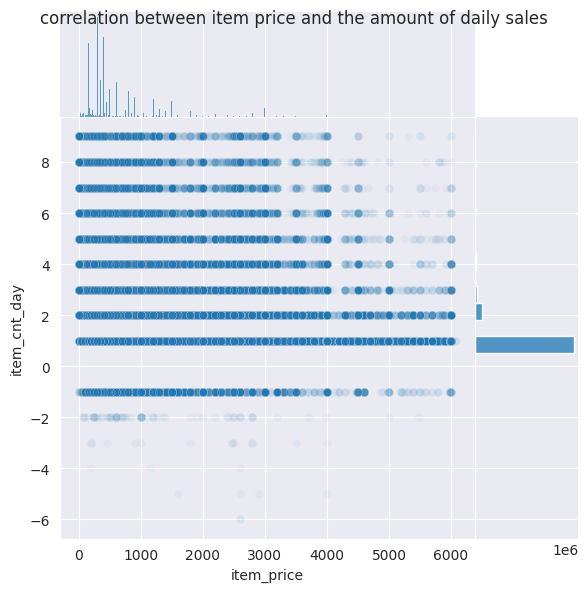

In [5]:
grid = sns.jointplot(data=data[['item_cnt_day', 'item_price']], x='item_price', y='item_cnt_day', space=0, ratio=4, joint_kws={'alpha':0.05})
grid.figure.suptitle('correlation between item price and the amount of daily sales')
plt.show()

# the graph is really bad, but I couldn't find a better way to visualise this

I wanna see if items' prices change over time because it might affect the way we construct a feature from this

From what we see on the figure, we can colclude that cheaper items are sold (and returned) more often overall, and items are mostly sold once or twice a day

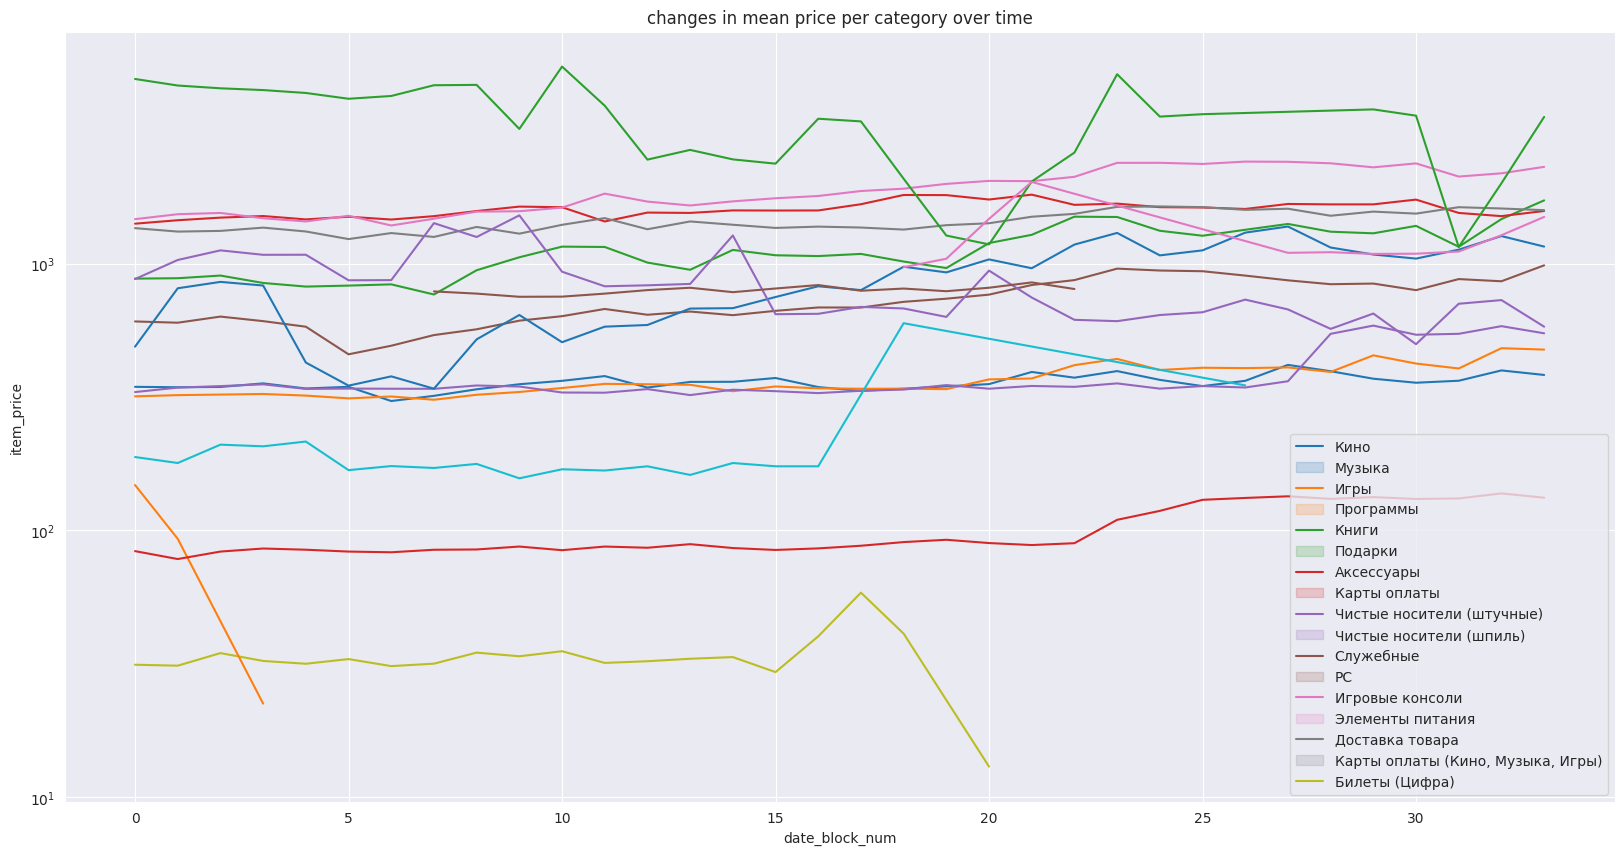

In [25]:
plt.figure(figsize=(20, 10))
plt.yscale('log')
for item_cat in data['general_cat'].unique():
    dtp = data[data['general_cat']==item_cat][['date_block_num', 'item_price']].groupby('date_block_num', as_index=False).mean()
    sns.lineplot(dtp, x='date_block_num', y='item_price',
                 palette=sns.color_palette('Set2'))

plt.legend(labels=data['general_cat'].unique())
plt.title('changes in mean price per category over time')
plt.show()

we can see the prices change over time, but it might not be true for some categories since we 
plot the mean value which is affected by the value counts. plotting each item separately isn't
quite a good idea (given how many different items we have), so we're rely on catagories instead.

this might lead to useless computations sometimes, but overall assuming the prices change (and hence
taking in account smth like rolling mean, or simply the last few months) is more relient than assuming
they're constant

#### categorial data

here I'm trying to see a distibution of the amount of items sold daily with respect to different values of categorial columns

In [6]:
def barplots(df: pd.DataFrame, columns: list[str], target='item_cnt_day', hue: str = None, aggregation: str = 'sum', title: str = None, show_line=False, legend=False, rotate=False):

    figsize = (20, 5*len(columns))
    plt.figure(figsize=figsize)
    if title:
        plt.suptitle(title, fontsize=16)

    for idx, col in enumerate(columns):
        _hue = hue
        data_to_plot = None
        used_cols = [target, col]
        if _hue:
            used_cols.append(_hue)
        if aggregation == 'sum':
            data_to_plot = df[used_cols].groupby(used_cols[1::]).sum()
        elif aggregation == 'mean':
            data_to_plot = df[used_cols].groupby(used_cols[1::]).mean()
        elif aggregation == 'max':
            data_to_plot = df[used_cols].groupby(used_cols[1::]).max()
        plt.subplot(len(columns), 1, idx+1)
        bp = sns.barplot(data_to_plot, x=col, y=target, hue=_hue,
                            palette=sns.color_palette('Set2'), legend=legend)
        if show_line:
            sns.lineplot(data=data_to_plot, x=col, y=target,
                         palette=sns.color_palette('Set2'))
        if rotate:
            for item in bp.get_xticklabels():
                item.set_rotation(90)
    plt.subplots_adjust(bottom=0.1,
                        top=0.9,
                        hspace=0.2)
    plt.show()

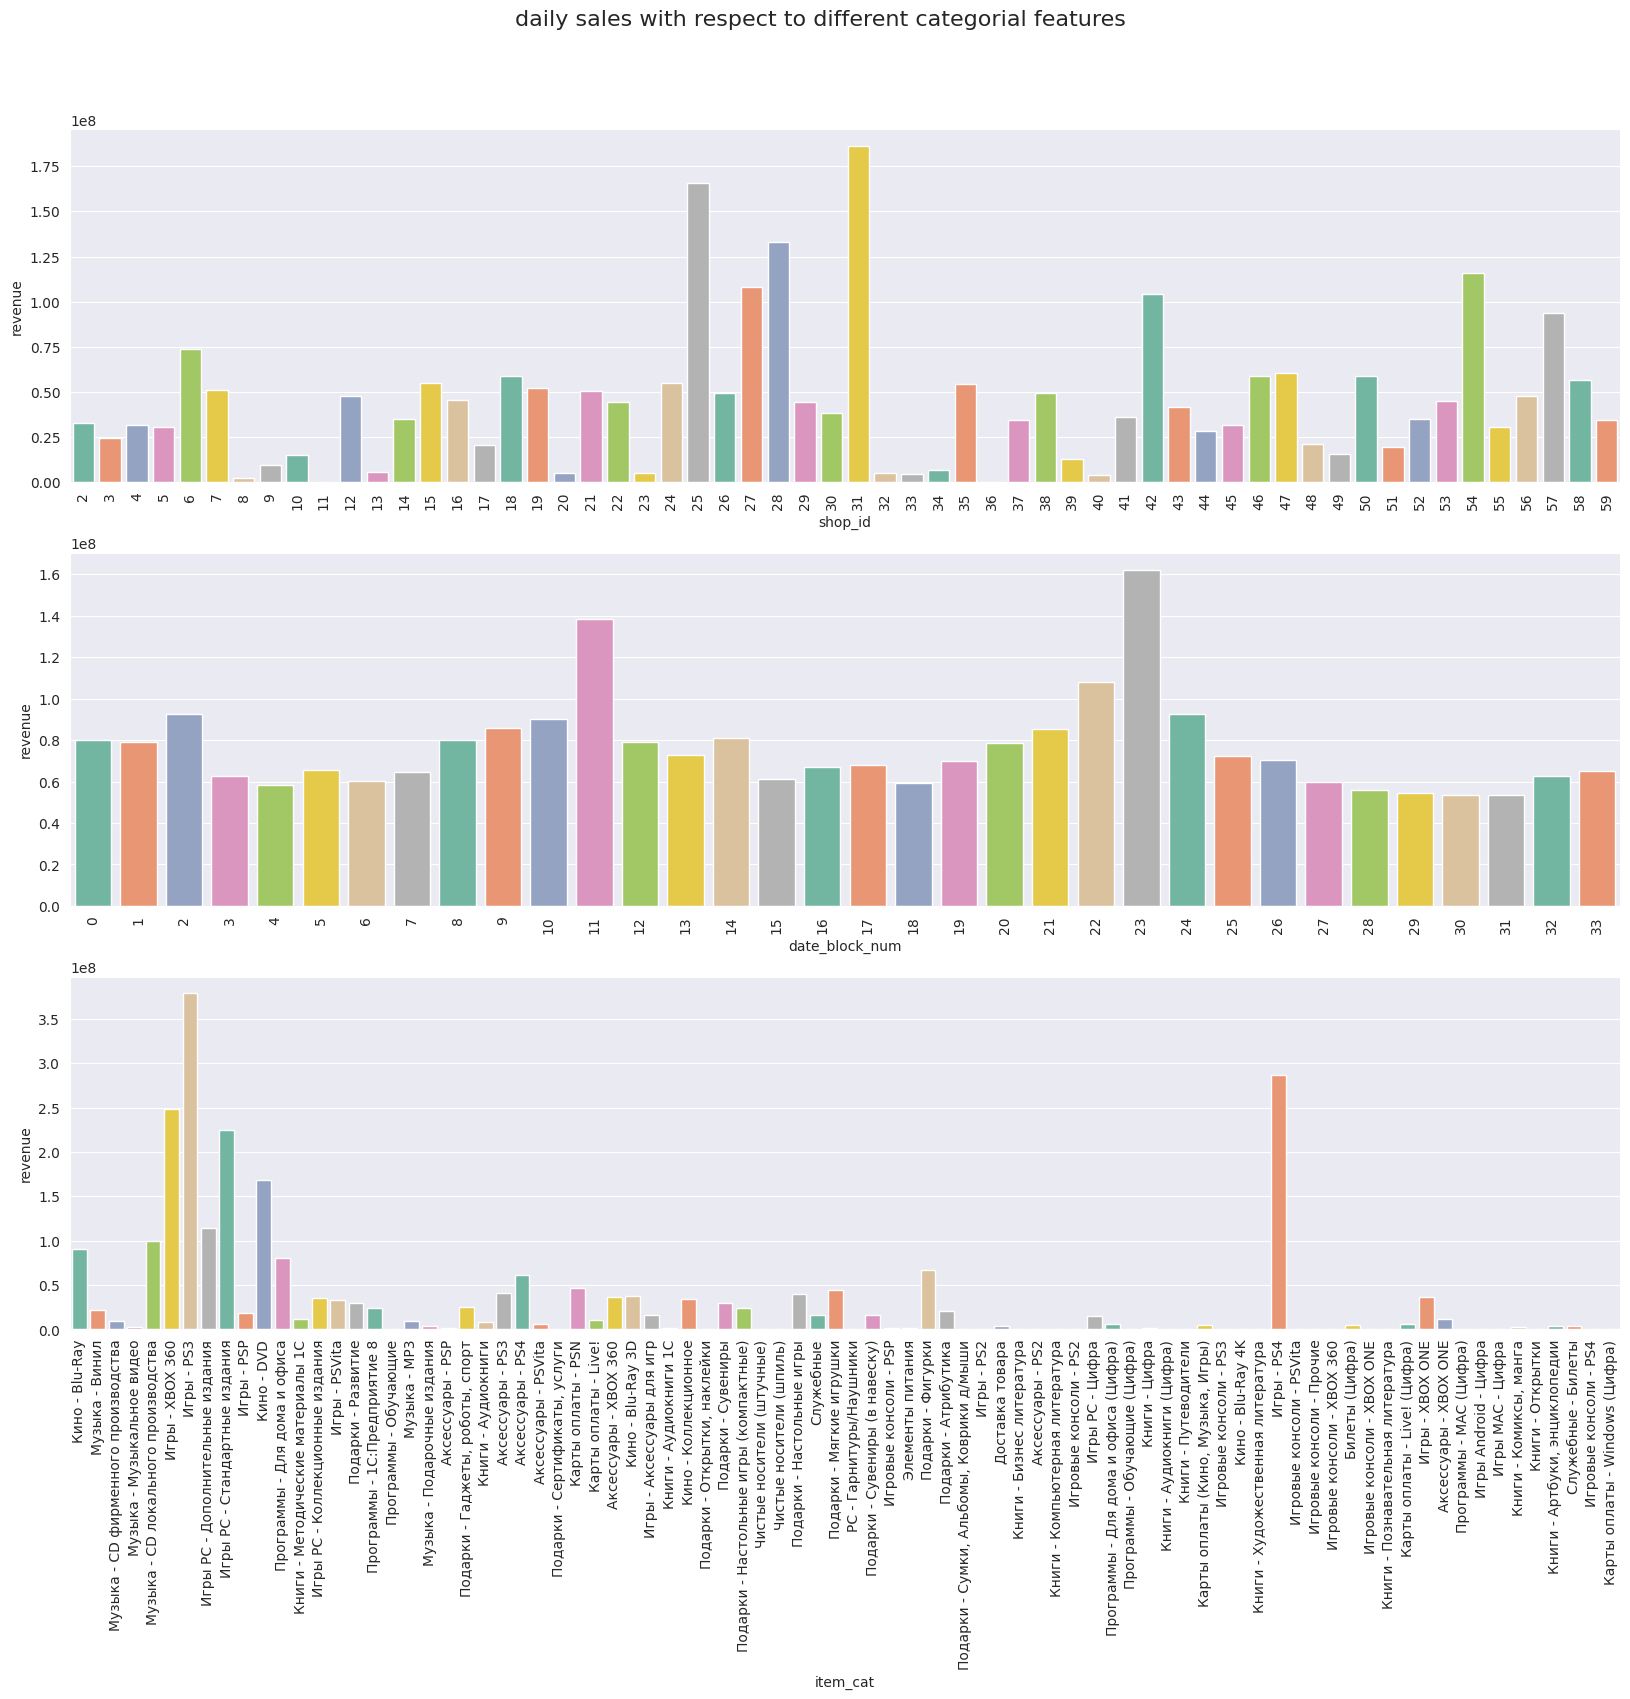

In [7]:
cols = ['shop_id', 'date_block_num', 'item_cat']

barplots(data, cols, title='daily sales with respect to different categorial features', aggregation='sum', target='revenue', rotate=True)

the amount of items sold has a sigificant drop around the 24th month mark, so let's see it as a line as well

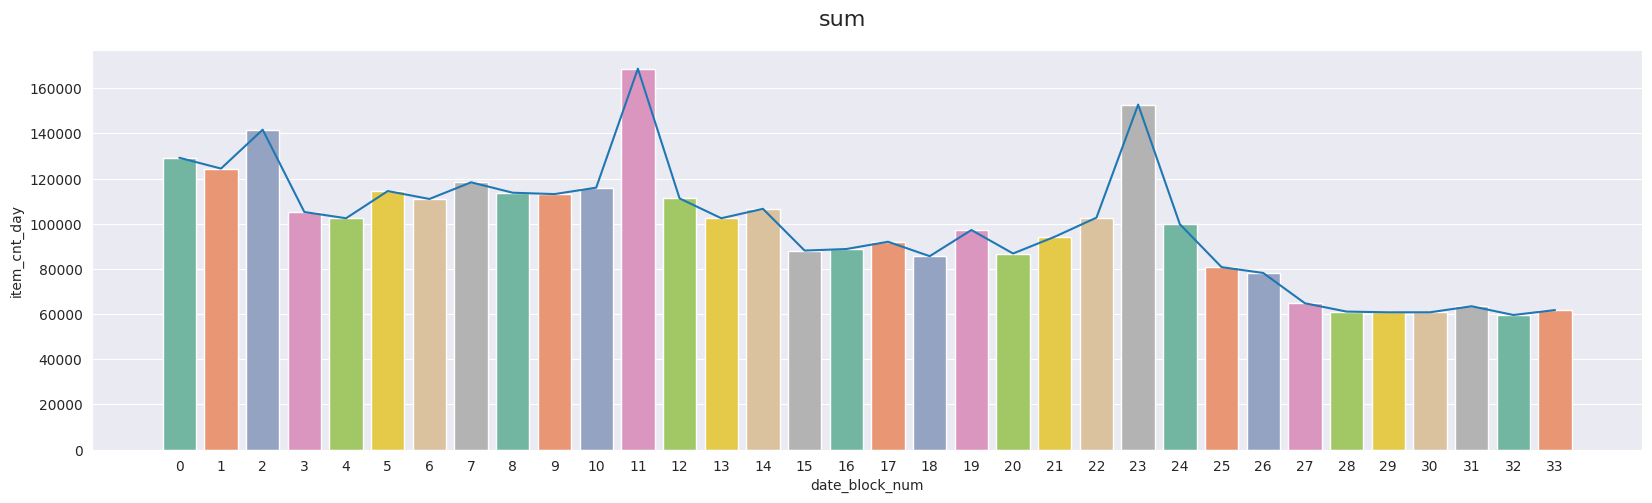

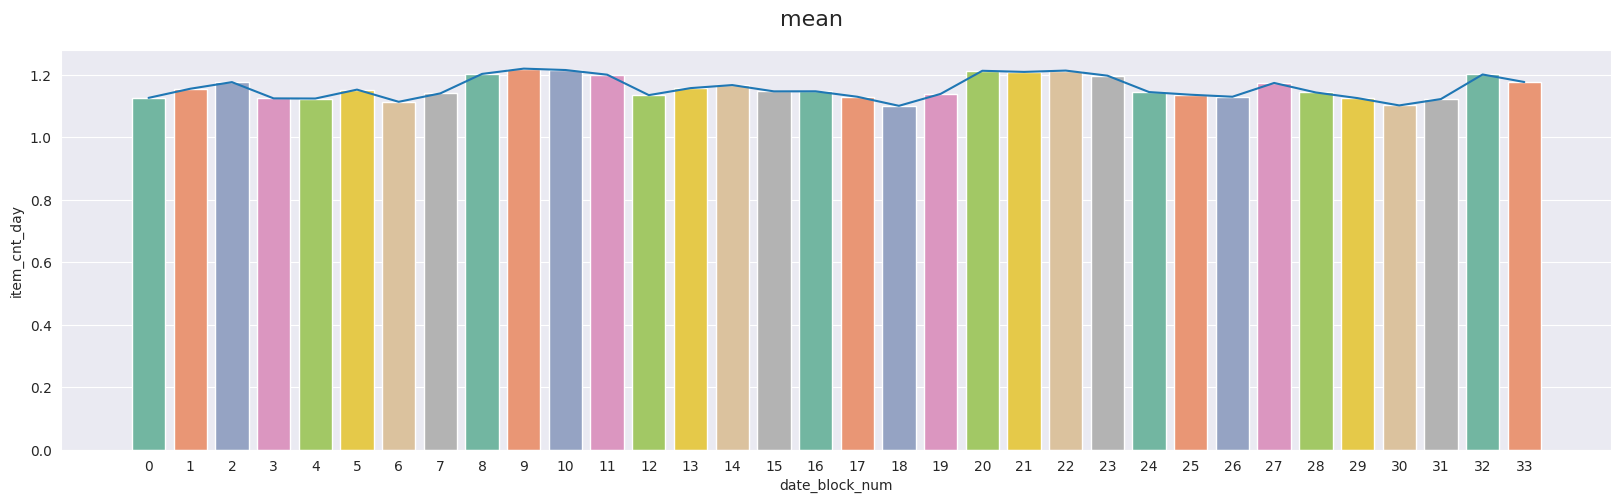

In [8]:
barplots(data, ['date_block_num'], aggregation='sum', show_line=True, title='sum')
barplots(data, ['date_block_num'], aggregation='mean',
         show_line=True, title='mean')

we can see that the amount of items sold increases every 12 months (which we already saw during DQC) and remains approx. the same during the whole period (though, the overall sales do decrease a little by the end of the period)

at the same time, we can see that the amount of items sold has quite a high variance depending on the category and the shop, so that gives us a hint that those two columns will be an important factor while predicting the future sales.

also, we can see that the overall revenue during the last few months decreased a lot, while mean spiked to its all-time highest value. this probably means that by the end of the period pople started buying more expensive items, and less cheap ones

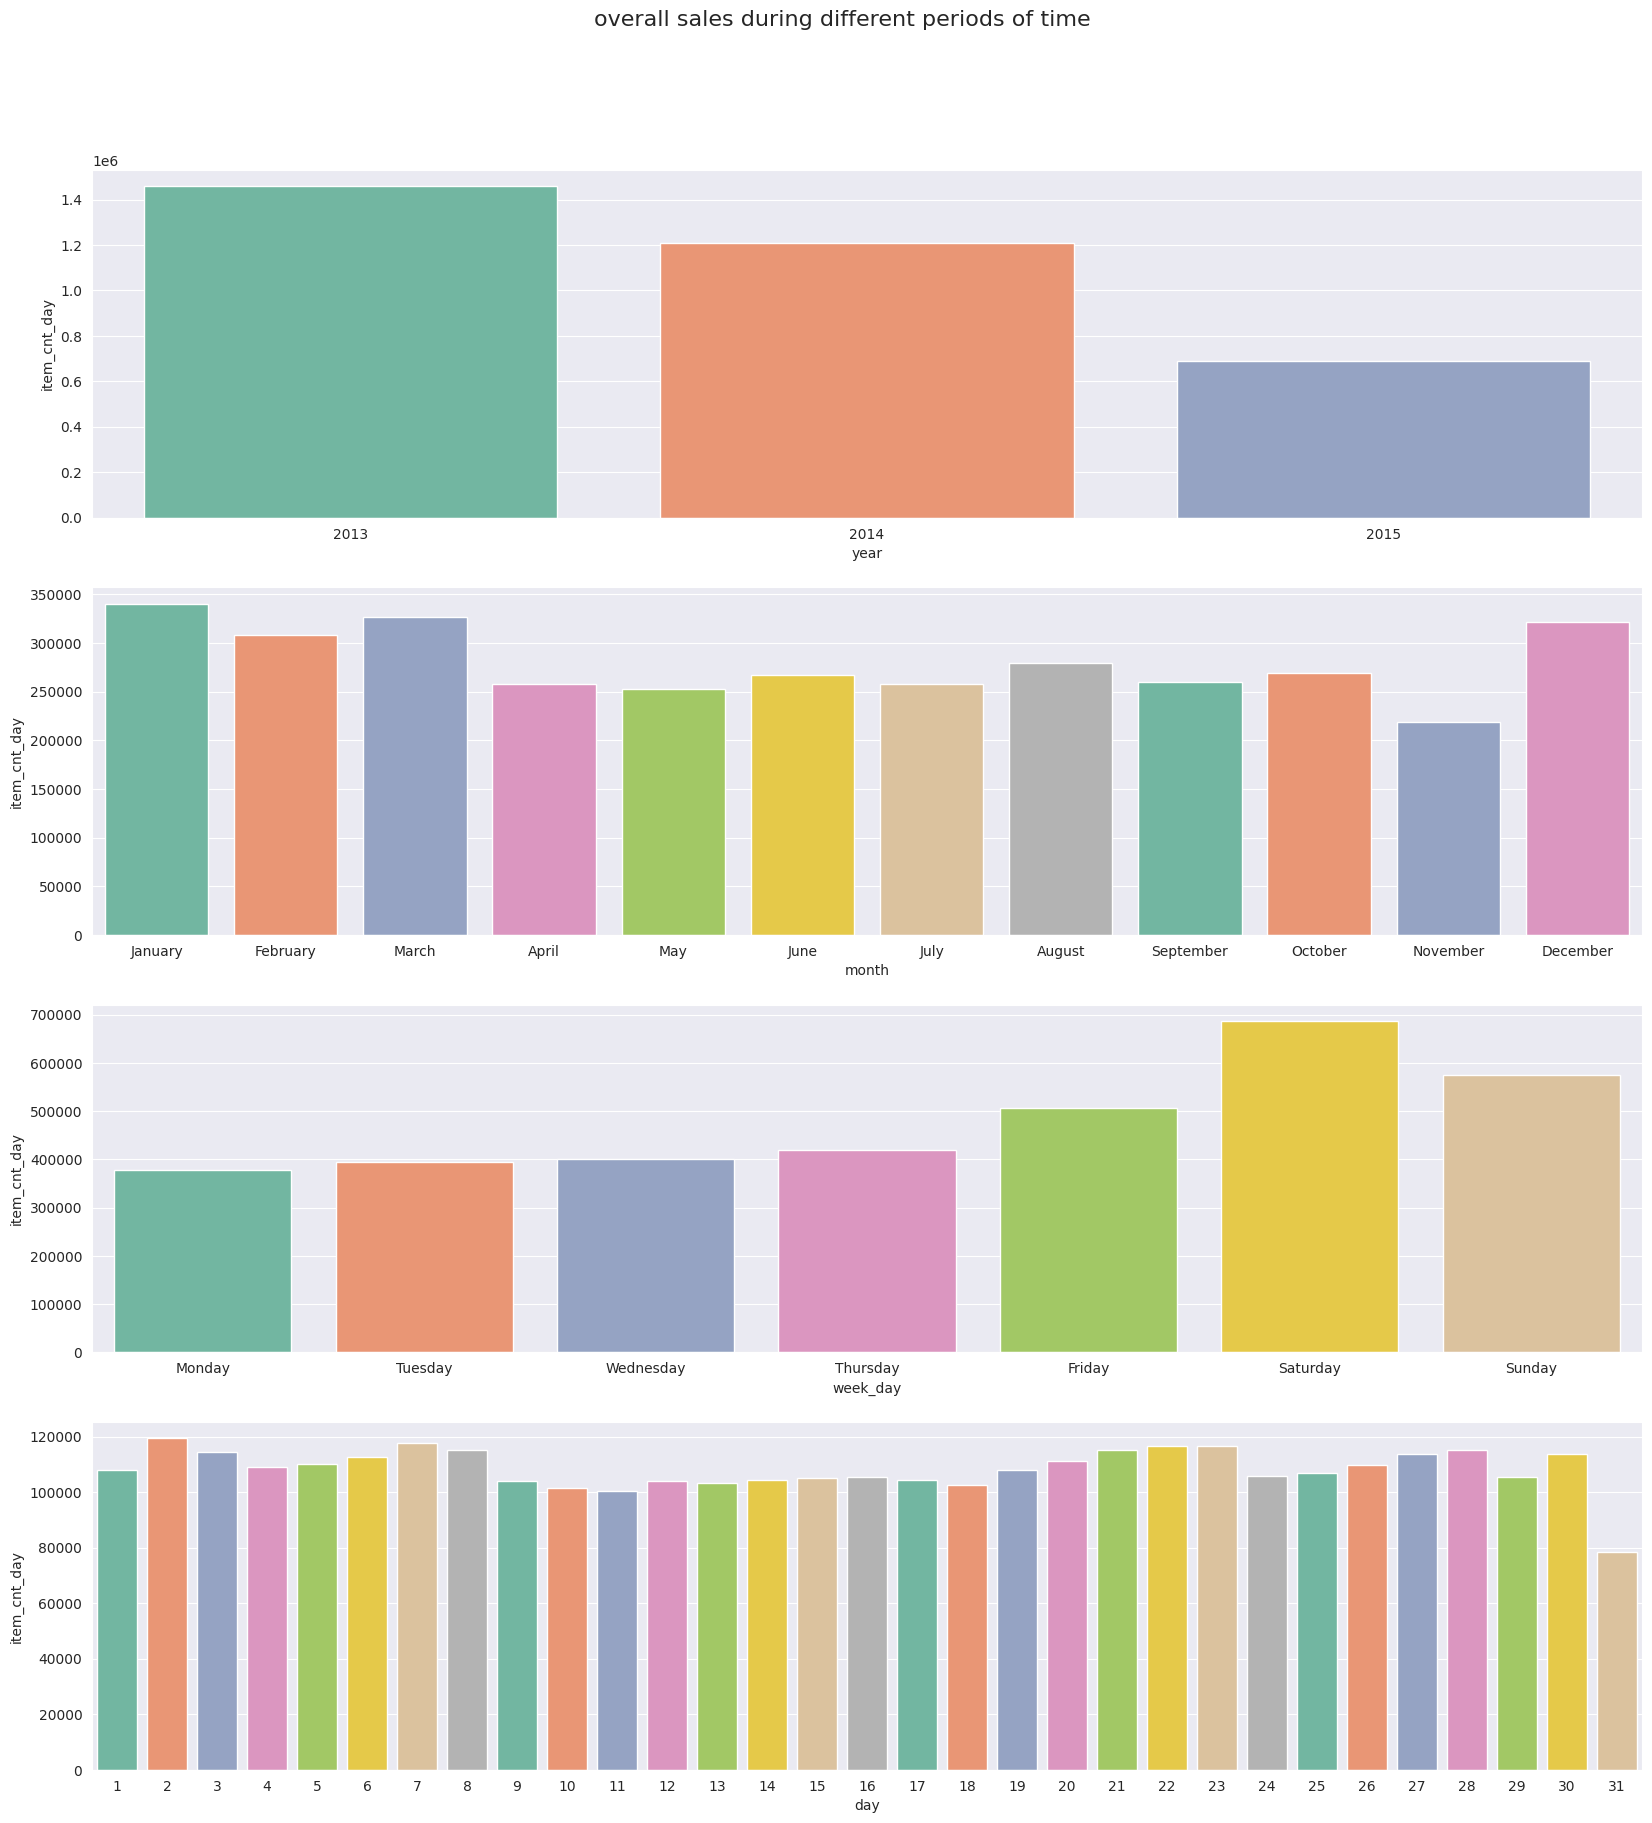

In [9]:
cols = ['year', 'month', 'week_day', 'day']

barplots(data, cols, title='overall sales during different periods of time')

here we can see the reason for sales droppping at months № 3, 15 and 24: the sales are very high in December bc of the new year, then in the next three months they decrease, but there are still some holidays (like the valentine's day and the international women's day) which cause the sales to stay higher than average during those months. after that, there's not that much holidays, so the sales decrease even further.

besides that, these three plots show us the following information:
- as expected, the sales drop over time, we can see the amount of items sold decrease each year. the sales over the last year are approx. twice as low as during the first year
- there's no strong trend of the amount of items sold over the course of one year. however, the sales rise around the new year (and, apparently, in march)
- sales remain approx. the same over the working days, but rise drastically from friday to sunday (esp. on saturday)
- overall sales do not depend on the day of the month (we can see a drop at 31, but that's probably due to the fact that some months have only 30 days)

since this data seems quite significant, it may be a good thing to include those values as input for the future model

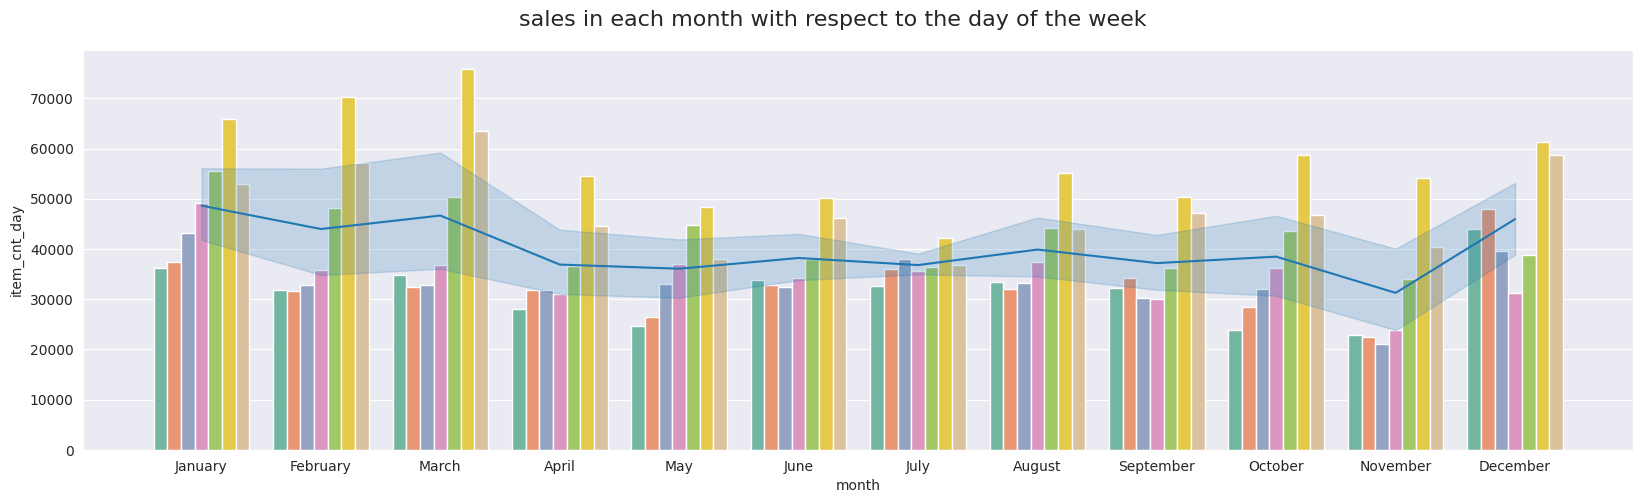

In [10]:
cols = ['month']
# data_to_plot = data[['date', 'shop_id', 'item_cnt_day']].groupby('date').sum()
barplots(df=data, columns=cols, hue='week_day', aggregation='sum', show_line=True, title='sales in each month with respect to the day of the week')

as we may see, for some reason the working day sales remain the same over different months (dropped in November though), but the weekend sales are much higher in Jan, Feb and March.

## Aggregating shops and categories

the idea is to have some sort of a more generalized groups for shops and items so that we can
see if maybe some items are more popular at a certain place. this might also help since we
might be able to construct a more useful (?) feture from this, rather than having 80+ different 
categories most of which are quite similar to each other. for example accessories for PS4 and PS5
are listed as spearate in the dataset, howerver, de facto they're really similar.

#### Shops -> cities

Let's first look at the mean target value for shops to see what info we can extract

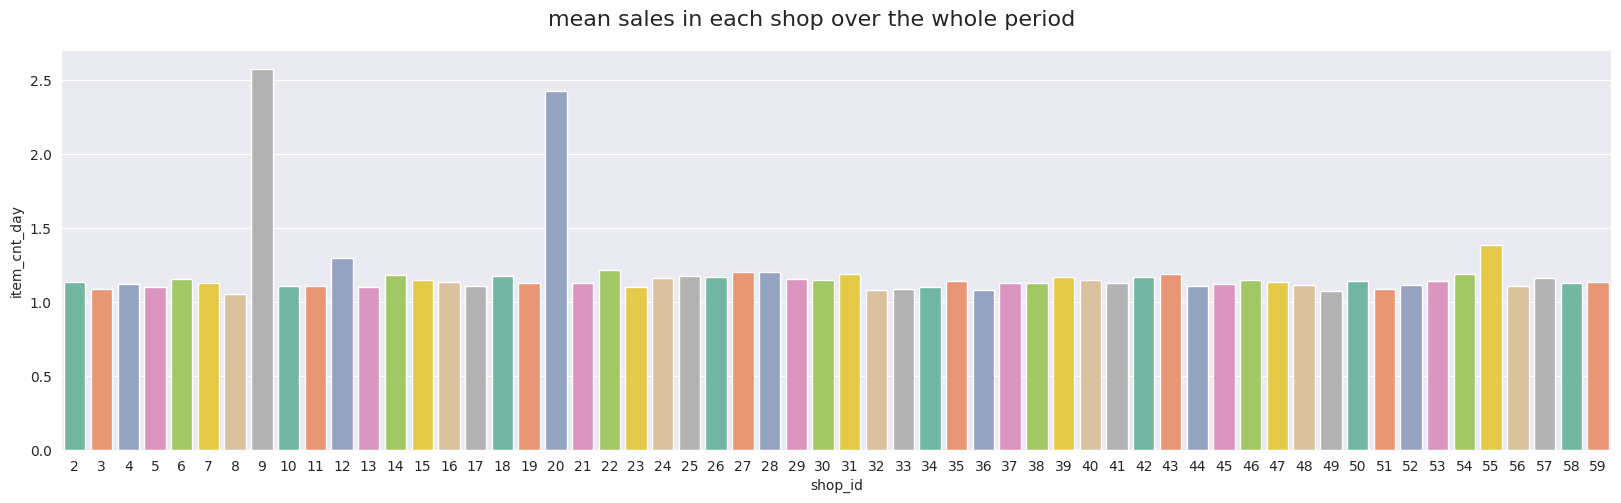

In [11]:
barplots(data, ['shop_id'], aggregation='mean', title='mean sales in each shop over the whole period')

In [17]:
c1 = data['shop_id'] == 9
c2 = data['shop_id'] == 20
data[c1 | c2]['shop_name'].unique()

array(['Выездная Торговля', 'Москва "Распродажа"'], dtype=object)

aside from the two shops in the above cell, average sales per shop don't seem to have a high variance.
however, the sum of sales per shop does variate a lot, so it might be an informative thing

In [ ]:
groups = ['date_block_num', 'city']

data['city'] = data['shop_name'].apply(lambda x: x.split()[0])
mean_target = data.groupby('city')['item_cnt_day'].mean()
data['target_encoded'] = data['city'].map(mean_target)

In [ ]:
cities = data[['shop_id', 'city']].groupby('shop_id', as_index=False)['city'].unique()
cities = pd.DataFrame(cities)
cities['city'] = cities['city'].apply(lambda x:x[0])
cities = cities.merge(data[['city', 'target_encoded']].groupby('city', as_index=False).mean(), on='city', how='left')

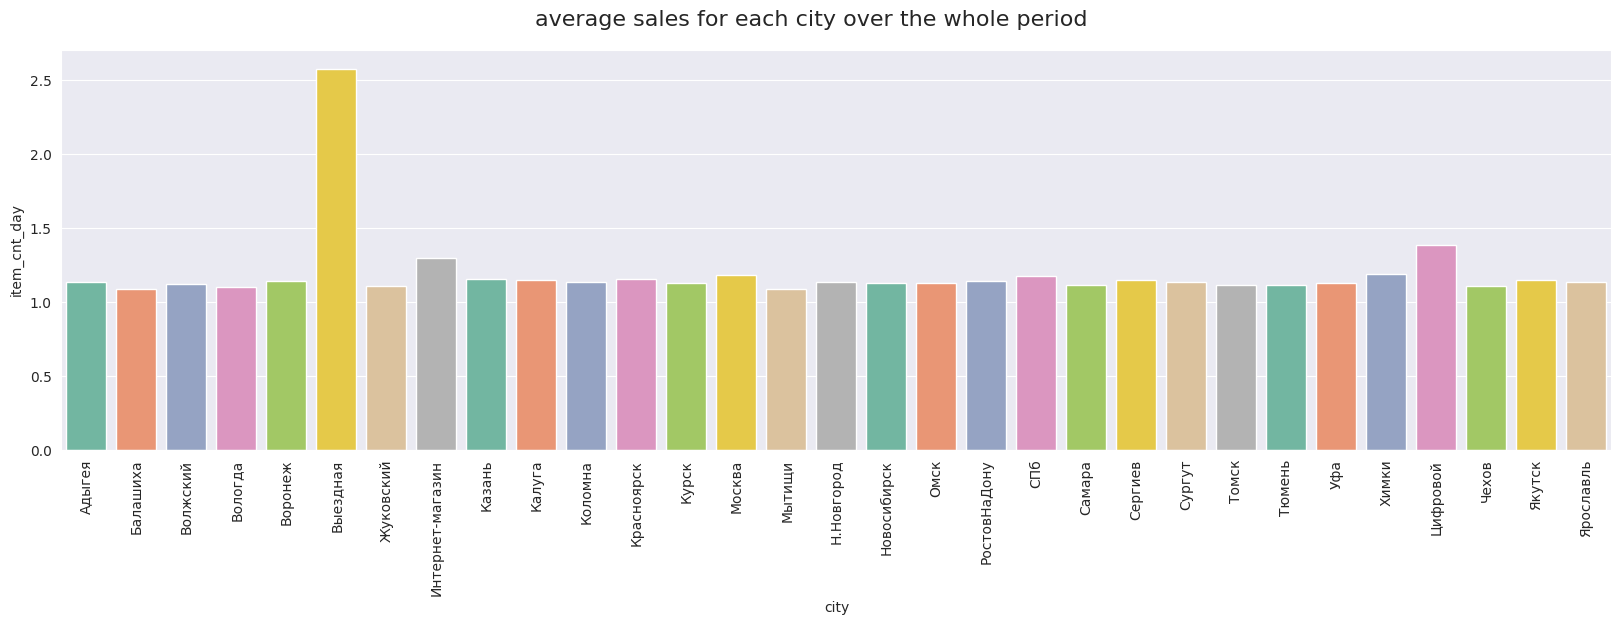

In [ ]:
barplots(data, ['city'], 'item_cnt_day', rotate=True, title='average sales for each city over the whole period', aggregation='mean')

apparently, this seems to have a very low variance (except for that one bin that's twice as high compared to others), 
which means this (and hence cities overall) probably won't be a useful feature in the future. however, we'll see 
later after checking feature importances.

it might appear that it changes during certain periods, so lets group by months and see

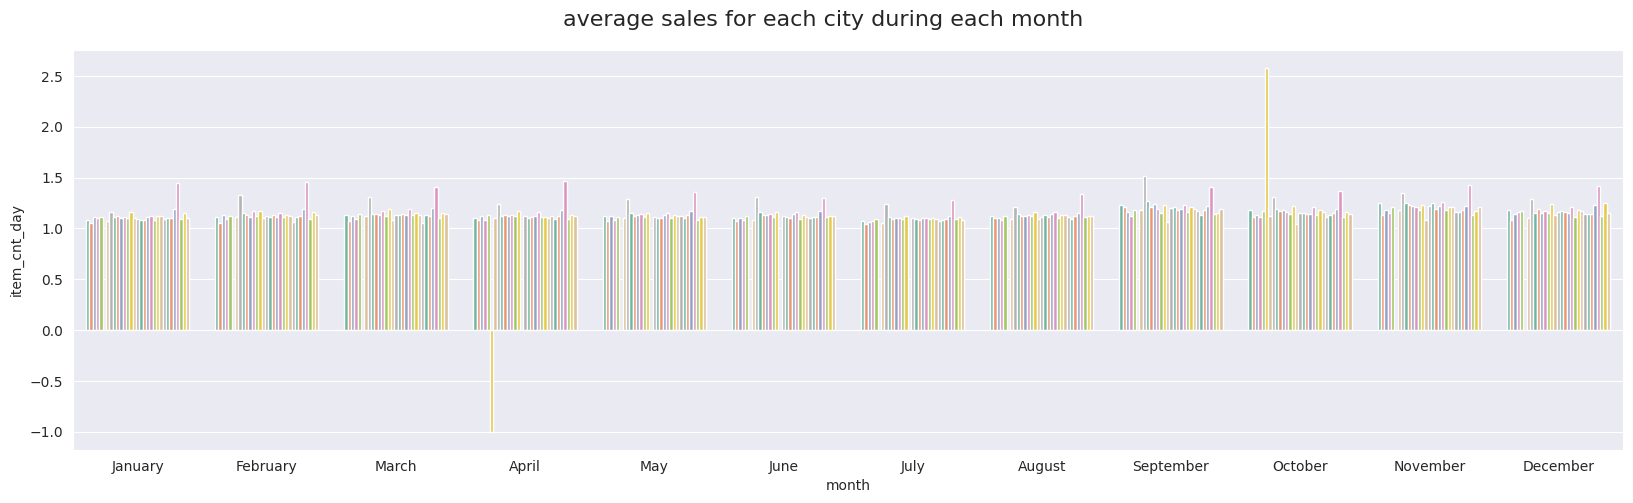

In [ ]:
barplots(data, ['month'], 'item_cnt_day', aggregation='mean', hue='city',
         title='average sales for each city during each month')

as we can see, the situation is quite similar each month, so we can be even more certain that this feature
won't be very helpful since it contains a low amount of information about the target

#### generalizing categories

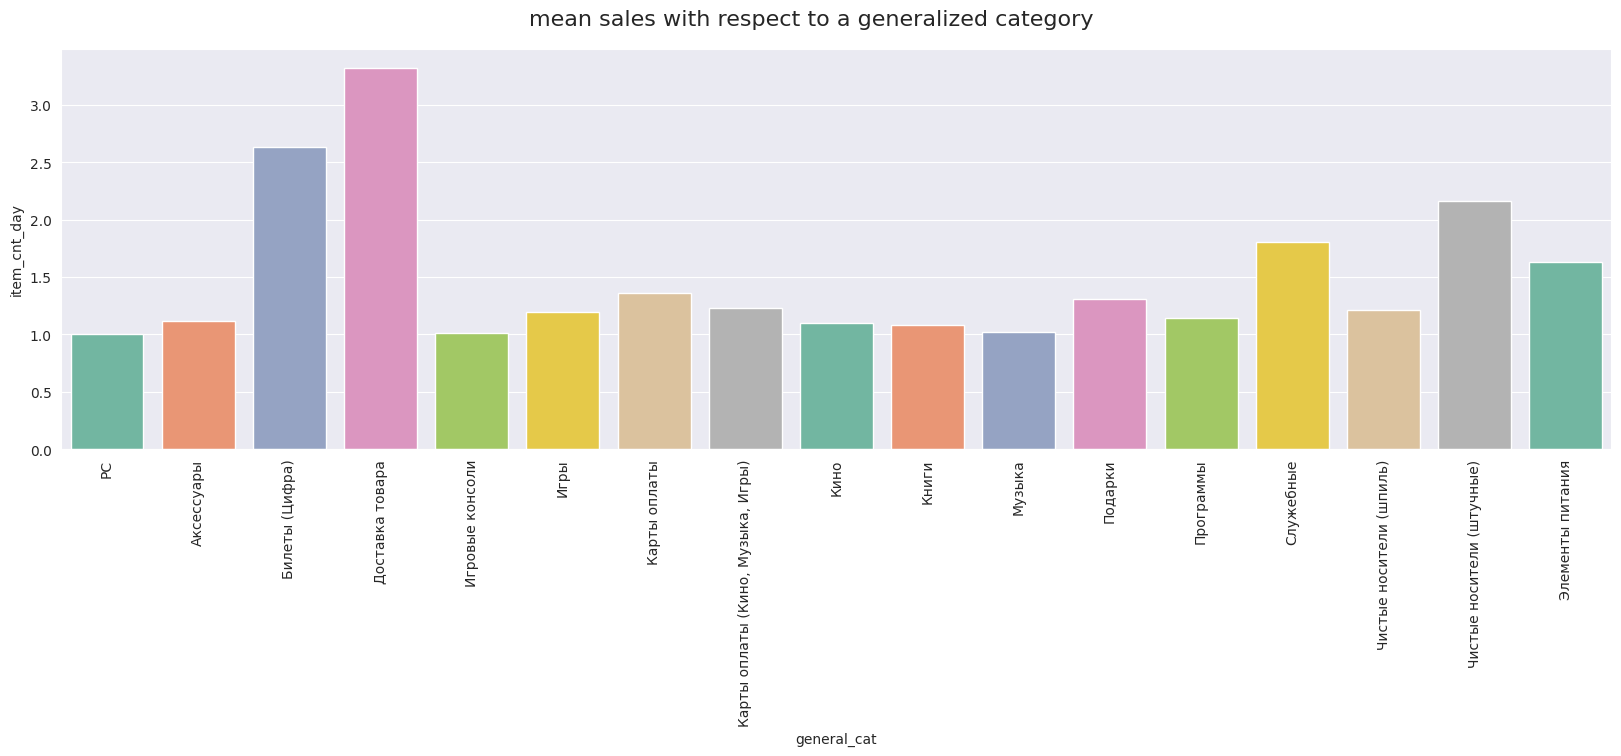

In [ ]:
barplots(data[['general_cat', 'item_cnt_day']], ['general_cat'], aggregation='mean', title='mean sales with respect to a generalized category', rotate=True)

from the plot we can see that the category might indeed be very useful, since the target value is highly dependant on it.
like with cities, we'll see if this hypothesis is true once we can see feture importances.

let's see if maybe the picture changes over time:

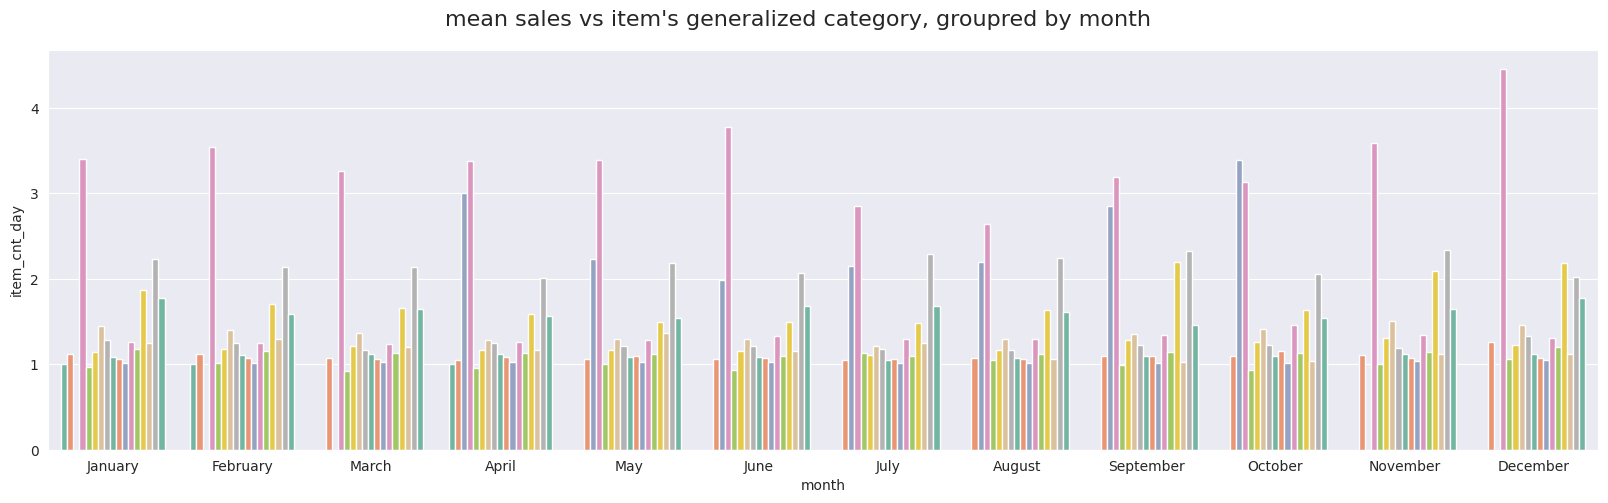

In [ ]:
barplots(data[['general_cat', 'item_cnt_day', 'month']], ['month'], hue='general_cat', aggregation='mean',
         title='mean sales vs item\'s generalized category, groupred by month')

seems like these don't change a lot over time. but it seems like a useful feature anyway

## time series analysis

In [ ]:
target = 'item_cnt_day'
data['detrended'] = detrend(data[target])

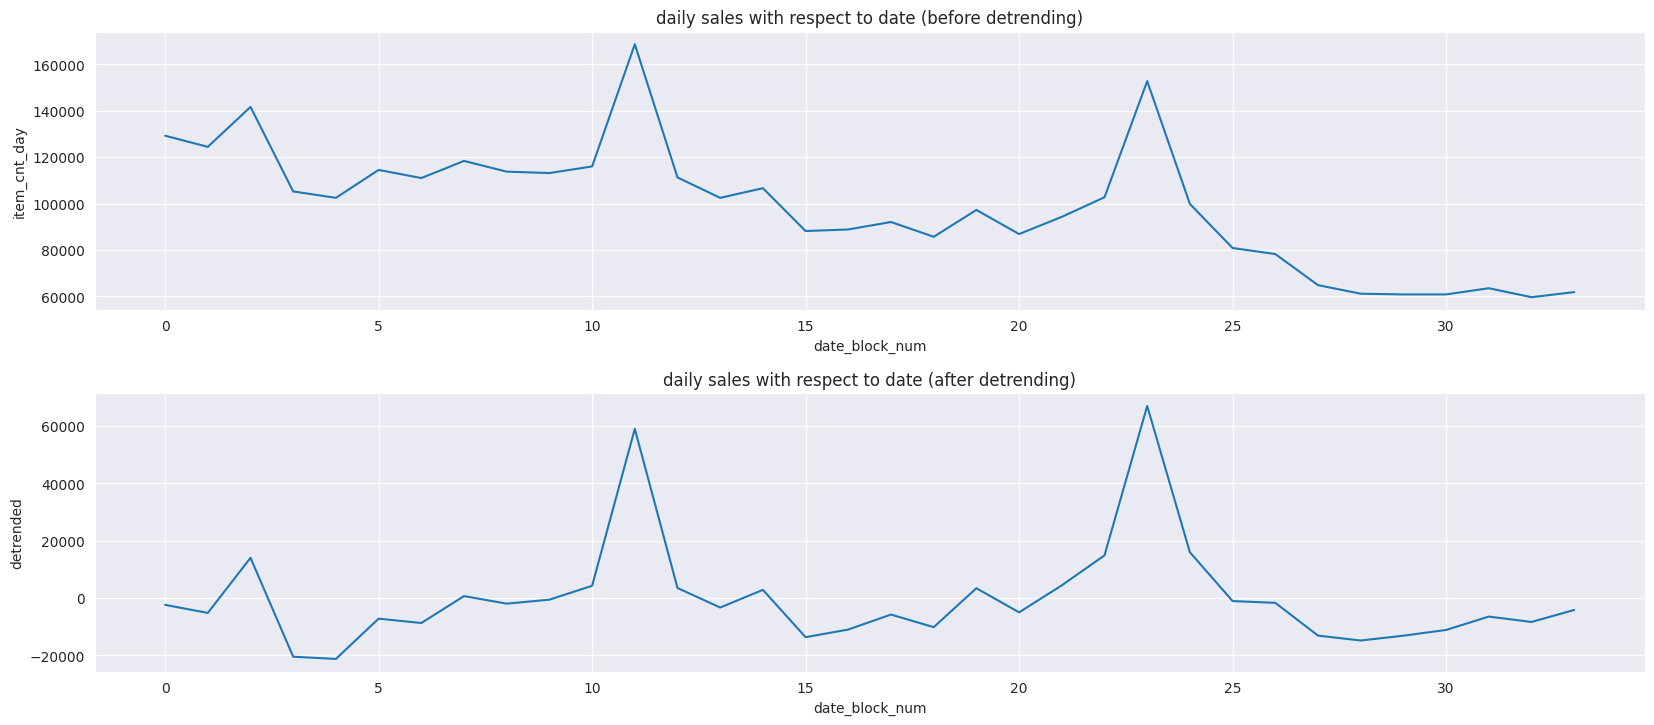

In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(2, 1, 1)

plt.title('daily sales with respect to date (before detrending)')
data_to_plot = data[['date_block_num', 'item_cnt_day']].groupby('date_block_num').sum()
sns.lineplot(data=data_to_plot, x='date_block_num', y='item_cnt_day')
plt.subplot(2, 1, 2)
plt.title('daily sales with respect to date (after detrending)')
data_to_plot['detrended'] = detrend(data_to_plot[target])
sns.lineplot(data=data_to_plot, x='date_block_num', y='detrended')
plt.subplots_adjust(bottom=0.1,
                    top=0.9,
                    hspace=0.3)
plt.show()

this plot s mostly used to see how detrending works. on the first plot we can see a slight decrease in sales over time

In [25]:
_, ax = plt.subplots(2, 1, figsize=(20, 10))
lags = 11
period = ['month', 'shop_id', 'item_id']
# data_to_plot = data.groupby(period).agg(item_cnt_day = pd.NamedAgg(column='item_cnt_day',aggfunc='sum'))
data_to_plot = data[['month', 'item_cnt_day']].groupby(period).mean()
data_to_plot['detrended'] = detrend(data_to_plot[target])

plot_acf(data_to_plot['item_cnt_day'], ax=ax[0], title='autocorrelation in non-detrended data', lags=lags)
plot_acf(data_to_plot['detrended'], ax=ax[1],
         title='autocorrelation in detrended data', lags=lags)
plt.subplots_adjust(bottom=0.1,
                    top=0.9,
                    hspace=0.2)
plt.show()

we can extract some of those spikes as new features, because they seem to correlate with current values. the significant ones are 1 and 4 (maybe 3 and 5 as well)

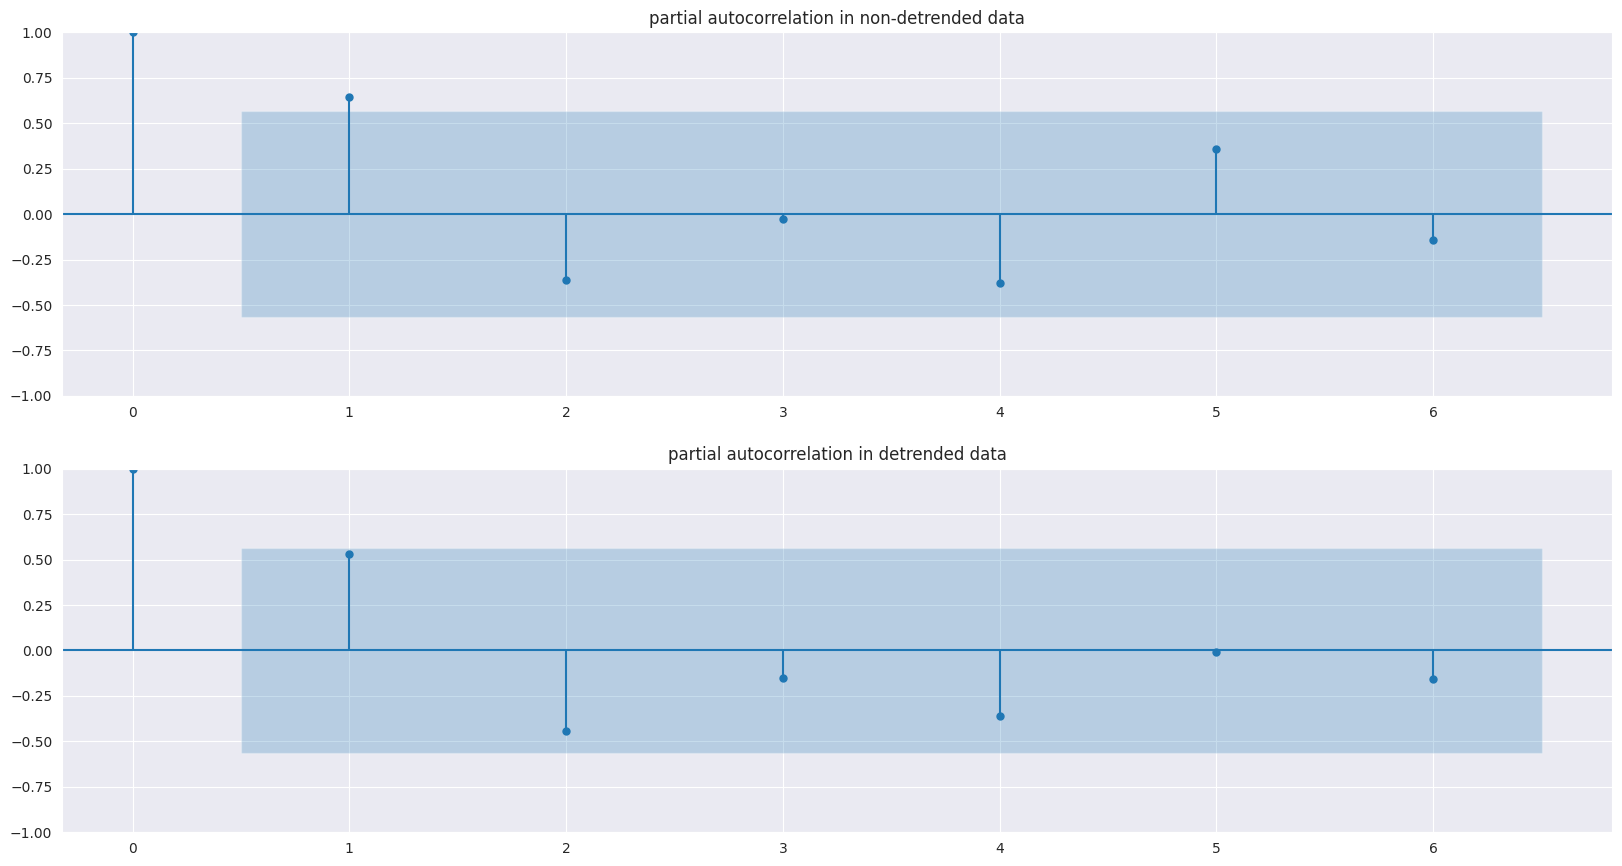

In [19]:
_, ax = plt.subplots(2, 1, figsize=(20, 10))
plot_pacf(data_to_plot['item_cnt_day'], ax=ax[0],
         title='partial autocorrelation in non-detrended data')
plot_pacf(data_to_plot['detrended'], ax=ax[1],
         title='partial autocorrelation in detrended data')
plt.subplots_adjust(bottom=0.1,
                    top=0.9,
                    hspace=0.2)
plt.show()

## Conclusion

- we can see some time-related patterns in the data (e.g. increased sales on weekends and suring holidays)
- the amount of sales does not highly depend on the day of the month, so other time-related features will be more important
- overall amount of sales decreases over time, which leads to the revenue being almost twice as small in 2015 compared to 2013
- some shops and item categories are significantly more popular than the other ones, which makes those features quite important during predictions
- some of the lagged values can be used as features later, because they have a high correlation to the current value

In [25]:
list(data.columns)

['date',
 'date_block_num',
 'shop_id',
 'item_id',
 'item_price',
 'item_cnt_day',
 'item_name',
 'item_category_id',
 'shop_name',
 'item_category_name',
 'year',
 'month',
 'day',
 'week_day',
 'item_cat',
 'revenue',
 'city',
 'target_encoded',
 'general_cat',
 'detrended']

## Possible features

- `date` - won't be used since we're predicting montly sales
- `month` - can be used, since we saw sales change drastically in some months. 
it also can be encoded using some periodical functions, so in the end features will probably be:
    - $\sin{\frac{2m\pi}{12}}$
    - $\cos{\frac{2m\pi}{12}}$
    
    where $m$ is the month's serial number
- `year` - the year itself might not be that useful, but maybe sales during the *previous*
year might be an important factor
- `date_block_num` is quite similar to month, but less informative and non-periodical, 
so there's no poin in using it
- `day` and `week_day` should not be used for the same reason as `date`
- `general_cat` seems like a very informative feature that isn't very expensive so encode 
(even if we use OHE)
- `item_cat`(alias `item_category`/`item_category_id`) is a more specific version of `general_cat`. 
it provides useful information too, but is a little noisy and maybe more expensive to use. 
I'll probably try both and see which one has better results.
- `city`, that's derived from the shop name doesn't seem to carry much info 
(except for a single value which isn't even a city).
I'll try using it as a feature anyways, but I don't expect much
- `shop_id` (alias `shop_name`) is somewhat controversial since the sum varies a lot, while 
mean is approx. the same for all the shops. I'll try using both mean and sum over the previous 
month as a feature and see if it achieves better results
- `item_price` should be quite useful since we know cheaper items are bought way more frequently. 
hence, using item's price from previous month (or maybe mean prices over the last few months)
- `revenue` which is a sum of $price\cdot count$ per shop and item might be useful, however, 
`item_price` seems like a simplier feature with a better connection to target